In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class_names=['Apple__Apple_scab','Apple__Black_rot','Apple__Cedar_apple_rust',
            'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Apple___Healthy','Grape___Black_rot','Corn_(maize)___Northern_Leaf_Blight']
class_names_label={class_name: i for i , class_name in enumerate(class_names)}
nb_classes=len(class_names)
IMAGE_SIZE=(150,150)
BATCH_SIZE=32


In [ ]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset=datasets.ImageFolder(root='/content/drive/MyDrive/plant disease using CNN/train',transform=transform)
test_dataset=datasets.ImageFolder(root='/content/drive/MyDrive/plant disease using CNN/test',transform=transform)

In [ ]:
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
n_train=len(train_dataset)
n_test=len(test_dataset)

print(f"Number of training examples: {n_train}")
print(f"Number of testing examples: {n_test}")
print(f"Each image is of size: {IMAGE_SIZE}")


Number of training examples: 106
Number of testing examples: 106
Each image is of size: (150, 150)


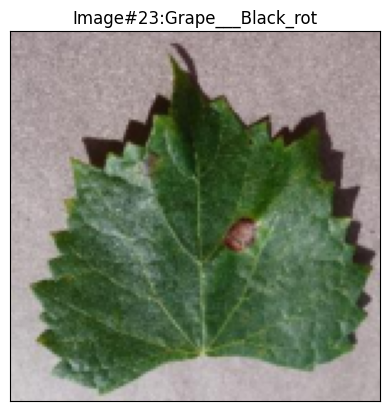

In [ ]:
#visualize the dataset
def display_random_image(loader,class_name):
  dataiter=iter(loader)
  images, labels =next(dataiter)
  index=np.random.randint(len(labels))
  image= images[index].numpy().transpose(1,2,0)
  #reverse of normalization
  image=image*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406])
  image=np.clip(image,0,1)
  plt.figure()
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title(f'Image#{index}:{class_names[labels[index]]}')
  plt.show()
display_random_image(train_loader,class_names)

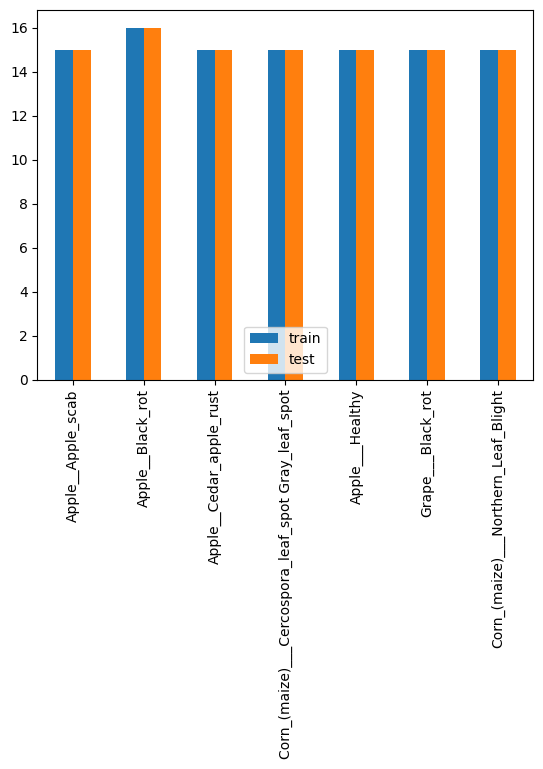

In [ ]:
#plotting dataset distribution
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train':train_counts,'test':test_counts},index=class_names).plot(kind='bar')
plt.show()

In [ ]:
def display_example(class_names,loader):
  num_examples=30
  dataiter=iter(loader)
  images,labels=next(dataiter)
  plt.figure(figsize=(10,10))
  for i in range(min(num_examples,len(images))):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image=images[i].numpy().transpose(1,2,0)
    image=np.clip(image,0,1)
    plt.imshow(image)
    plt.xlabel(class_names[labels[i].item()])
plt.show()

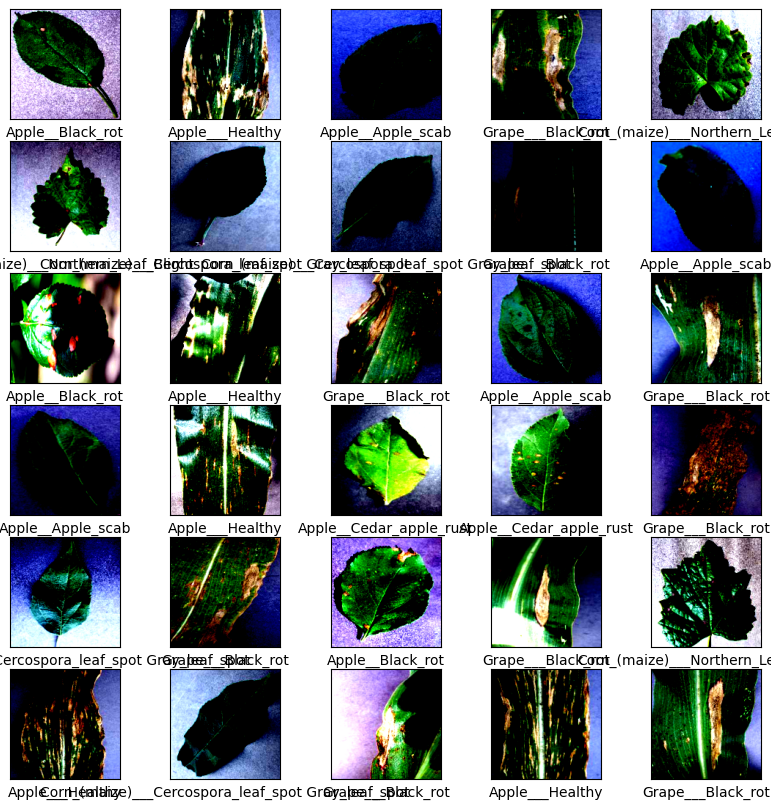

In [ ]:
display_example(class_names,train_loader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1=nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1)
    self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
    self.relu=nn.ReLU()
    self.dropout=nn.Dropout(0.5)
    self.flattened_size=self.get_flattened_size()
    #define fullyconnected layers
    self.fc1=nn.Linear(self.flattened_size,128)
    self.fc2=nn.Linear(128,len(class_names))
  def get_flattened_size(self):
    with torch.no_grad():
      x=torch.randn(1,3,150,150)
      x=self.conv1(x)
      x=self.relu(x)
      x=self.pool(x)
      x=self.conv2(x)
      x=self.relu(x)
      x=self.pool(x)
      return x.view(-1).size(0)
  def forward(self,x):
    x=self.conv1(x)
    x=self.relu(x)
    x=self.pool(x)
    x=self.conv2(x)
    x=self.relu(x)
    x=self.pool(x)
    x=x.view(-1,self.flattened_size)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    return x
batch_size=32
learning_rate=0.001
num_epochs =5
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
trainset=torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/plant disease using CNN/train',transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

testset=torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/plant disease using CNN/test',transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

class_names=trainset.classes
model=CNN()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(num_epochs):
  running_loss=0.0
  for i, (inputs,labels) in enumerate(trainloader,0):
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    if i%100==19:
      print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}, Loss: {running_loss/100:.4f}")
      running_loss=0.0
print("Training finished")
#Testing the model
correct=0
total=0
with torch.no_grad():
  for inputs,labels in testloader:
    outputs=model(inputs)
    _,predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()
print(f"Accuracy on the test set: {100*correct//total}%")

Training finished
Accuracy on the test set: 76%
